Weight of Evidence Encoding を試してみる  
https://www.kaggle.com/davidbnn92/weight-of-evidence-encoding  

### コンペの説明
Categorical Feature Encoding Challenge II  
https://www.kaggle.com/c/cat-in-the-dat-ii
>あなたのdatにもっと猫を見つけることができますか？  
  
>私たちは、第1回Cat in the Datコンテストへの参加とエンゲージメントをとても気に入っています。  
  
>これはそのような一般的なタスクであり、マスターするための重要なスキルであるため、  
私たちはカテゴリカルな特徴のみを含むデータセットをまとめました。  
  
>・binary features バイナリ特徴量  
・low- and high-cardinality nominal features 名義特徴量  
・low- and high-cardinality ordinal features 順序特徴量  
・(potentially) cyclical features 周期的な特徴量  
>このフォローアップ・コンペティションでは、  
カテゴリカル変数を符号化するという一般的な機械学習タスクでスキルを継続的に構築できるように、  
さらにチャレンジングなデータセットを提供します。  
  
>この課題では、欠落データだけでなく、特徴の相互作用の複雑さも加わります。  
  
>このPlaygroundコンテストでは、  
異なるアルゴリズムの異なるエンコーディング・スキームを試して、  
その性能を比較する機会を提供します。  
見つけたものをコミュニティで共有することをお勧めします。  
  
>どうやって始めればいいのか分からない場合は、  
Kaggleの機械学習中級コースのカテゴリ変数のセクションをチェックしてみてください。  
  
>楽しんでください  

### データの説明
>この競技では、バイナリの対象列の確率[0, 1]を予測することになります。  
データには、  
binary features バイナリ特徴量(bin_＊)、  
nominal features 名義特徴量(nom_＊)、  
ordinal features 順序特徴量(ord_＊)の他に、  
(潜在的に周期的な)曜日(曜日)と月の特徴量が含まれています。  
文字列序列特徴 ord_{3-5} は string.ascii_letters に従って語彙的に順序付けられています。  
  
>このコンペティションの目的は、  
様々な符号化戦略を探求することであるため。  
第1回のカテゴリー特徴エンコーディングチャレンジ  
(https://www.kaggle.com/c/cat-in-the-dat/data)とは異なり、  
このチャレンジのデータには欠落値と特徴の相互作用があります。  
  
>最初のカテゴリ特徴エンコーディングチャレンジとは異なり  
このチャレンジのデータには欠落した値と特徴の相互作用があります。（コンペの説明ここまで）

### ノート序文
>このノートブックでは、  
単純なロジスティック回帰モデルでの Weight of Evidence Encoding (WOEEncoder) の有効性を説明し、  
Target Encoding や CatBoost Encoding などの他のターゲットベースのエンコーディングと比較します。  
  
>結論から言うと、  
WOEEncoderは、少なくともバイナリ分類問題に対しては、  
Target EncodingやCatboostよりも一般的に優れた性能を発揮します。  
WOEEncoderをすべての名目特徴と周期的特徴にキャストすると、  
テストセットで78.355%のAUCスコアを得るのに十分で、  
TargetEncoderをWOEEncoderで置き換えると、  
（caesarlupumのこのノートhttps://www.kaggle.com/caesarlupum/2020-20-lines-target-encoding  
やこのノートhttps://www.kaggle.com/muhammad4hmed/easily-get-78-5-accuracyで見られるような）  
約78.50%から約78.56%までAUCスコアが改善されました。  
  
>理論的な説明についてはこの記事を、  
https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html  
ドキュメントについてはカテゴリエンコーダーのこのページを参照してください。  
https://contrib.scikit-learn.org/categorical-encoding/woe.html  
  
>簡潔に言うと、これがカテゴリ特徴量Fで何をするかというと、次のようになります。  
・それぞれのユニークな値xに対して、学習セットの対応する行を考慮する  
・全体の集合と比較して、これらの行の陽性の割合を計算します。  
・全体の集合と比較して、これらの行の負の割合を計算します。  
・これらの比率を取る(陽の割合/負の割合)  
・その比率の自然対数(log)をとって x に対応する証拠の重みを求め、  
 従って WOE(x) は x が正の代表であるか負の代表であるかに応じて正か負かのどちらかになります。  
・NaN は handle_missing オプションで、WOE=0 に設定される必要がある

>数値的な特徴については、ビンに関しても同じことを行います。  

In [162]:
# お試し
# positveが少なくなるとマイナス
import math
import pandas as pd
print("postiveが90%,negativeが10%の場合:", math.log(0.9/0.1))
print("postiveが70%,negativeが30%の場合:", math.log(0.7/0.3))
print("postiveが50%,negativeが50%の場合:", math.log(0.5/0.5))
print("postiveが30%,negativeが70%の場合:", math.log(0.3/0.7))
print("postiveが10%,negativeが90%の場合:", math.log(0.1/0.9))

postiveが90%,negativeが10%の場合: 2.1972245773362196
postiveが70%,negativeが30%の場合: 0.8472978603872037
postiveが50%,negativeが50%の場合: 0.0
postiveが30%,negativeが70%の場合: -0.8472978603872036
postiveが10%,negativeが90%の場合: -2.197224577336219


In [163]:
import numpy as np 
 
import os

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

import category_encoders as ce

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("max_columns",100)

In [164]:
test_features = pd.read_csv("./cat-in-the-dat-ii/test.csv")
train_set = pd.read_csv("./cat-in-the-dat-ii/train.csv")

In [165]:
# binary features バイナリ特徴量(bin_0～4)、  
# nominal features 名義特徴量(nom_0～9)、  
# ordinal features 順序特徴量(ord_0～5)のほかに
# (潜在的に周期的な)曜日(曜日)と月の特徴
train_set.head(3)

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,Bassoon,de4c57ee2,a64bc7ddf,598080a91,0256c7a4b,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0
1,1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,Theremin,2bb3c3e5c,3a3a936e8,1dddb8473,52ead350c,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0
2,2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,Bassoon,b574c9841,708248125,5ddc9a726,745b909d1,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0,0


In [166]:
# ターゲットは 0 or 1
display(train_set["target"].value_counts(dropna=False))
display(train_set[["target"]].describe().T)

0    487677
1    112323
Name: target, dtype: int64

,count,mean,std,min,25%,50%,75%,max
target,600000.0,0.187205,0.390076,0.0,0.0,0.0,0.0,1.0


In [167]:
train_targets = train_set.target
train_features = train_set.drop(['target'], axis=1)

In [168]:
# 平均
percentage = train_targets.mean() * 100
print("The percentage of ones in the training target is {:.2f}%".format(percentage))

The percentage of ones in the training target is 18.72%


### EXAMPLE

In [169]:
columns = [col for col in train_features.columns if col != 'id']

In [170]:
# WOEEncoder
woe_encoder = ce.WOEEncoder(cols=columns)
# Encode
woe_encoded_train = woe_encoder.fit_transform(
    train_features[columns], # x
    train_targets # y
).add_suffix('_woe') # カラム名の後ろに_woeを付ける

In [171]:
print("Encode前")
display(train_features[columns].head(3))
print("Encode後")
display(woe_encoded_train.head(3))

Encode前


,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,Bassoon,de4c57ee2,a64bc7ddf,598080a91,0256c7a4b,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0
1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,Theremin,2bb3c3e5c,3a3a936e8,1dddb8473,52ead350c,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0
2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,Bassoon,b574c9841,708248125,5ddc9a726,745b909d1,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0


Encode後


,bin_0_woe,bin_1_woe,bin_2_woe,bin_3_woe,bin_4_woe,nom_0_woe,nom_1_woe,nom_2_woe,nom_3_woe,nom_4_woe,nom_5_woe,nom_6_woe,nom_7_woe,nom_8_woe,nom_9_woe,ord_0_woe,ord_1_woe,ord_2_woe,ord_3_woe,ord_4_woe,ord_5_woe,day_woe,month_woe
0,0.048344,0.021896,-0.109369,-0.002853,-0.046488,-0.027431,0.234185,-0.131479,0.199906,0.127457,0.150344,-0.141177,-0.688260,-0.441818,-0.135446,0.314361,-0.096404,0.114060,-0.586839,0.219733,-0.316115,0.080953,-0.294371
1,-0.588414,-0.101291,-0.109369,-0.002853,0.052375,-0.027431,-0.430458,0.088878,-0.008637,-0.050968,0.047834,0.096111,-0.440078,0.066273,-0.234267,0.314361,0.274988,-0.079506,-0.384647,0.281077,0.299172,0.158142,0.139136
2,0.048344,-0.101291,-0.109369,-0.002853,-0.046488,-0.027431,-0.028966,-0.131479,-0.190902,0.127457,-0.033269,-0.155488,0.437258,-0.097937,0.004441,0.314361,0.001537,-0.412874,0.569908,0.088321,0.136851,-0.163834,0.153646


In [172]:
# エンコード前のｘ　と　エンコード後のｘ　を連結
train_features = train_features.join(woe_encoded_train)
train_features.head(3)

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,bin_0_woe,bin_1_woe,bin_2_woe,bin_3_woe,bin_4_woe,nom_0_woe,nom_1_woe,nom_2_woe,nom_3_woe,nom_4_woe,nom_5_woe,nom_6_woe,nom_7_woe,nom_8_woe,nom_9_woe,ord_0_woe,ord_1_woe,ord_2_woe,ord_3_woe,ord_4_woe,ord_5_woe,day_woe,month_woe
0,0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,Bassoon,de4c57ee2,a64bc7ddf,598080a91,0256c7a4b,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0.048344,0.021896,-0.109369,-0.002853,-0.046488,-0.027431,0.234185,-0.131479,0.199906,0.127457,0.150344,-0.141177,-0.688260,-0.441818,-0.135446,0.314361,-0.096404,0.114060,-0.586839,0.219733,-0.316115,0.080953,-0.294371
1,1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,Theremin,2bb3c3e5c,3a3a936e8,1dddb8473,52ead350c,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,-0.588414,-0.101291,-0.109369,-0.002853,0.052375,-0.027431,-0.430458,0.088878,-0.008637,-0.050968,0.047834,0.096111,-0.440078,0.066273,-0.234267,0.314361,0.274988,-0.079506,-0.384647,0.281077,0.299172,0.158142,0.139136
2,2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,Bassoon,b574c9841,708248125,5ddc9a726,745b909d1,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0,0.048344,-0.101291,-0.109369,-0.002853,-0.046488,-0.027431,-0.028966,-0.131479,-0.190902,0.127457,-0.033269,-0.155488,0.437258,-0.097937,0.004441,0.314361,0.001537,-0.412874,0.569908,0.088321,0.136851,-0.163834,0.153646


In [173]:
# エンコード後のカラム一覧
woe_encoded_cols = woe_encoded_train.columns
woe_encoded_cols

Index(['bin_0_woe', 'bin_1_woe', 'bin_2_woe', 'bin_3_woe', 'bin_4_woe',
       'nom_0_woe', 'nom_1_woe', 'nom_2_woe', 'nom_3_woe', 'nom_4_woe',
       'nom_5_woe', 'nom_6_woe', 'nom_7_woe', 'nom_8_woe', 'nom_9_woe',
       'ord_0_woe', 'ord_1_woe', 'ord_2_woe', 'ord_3_woe', 'ord_4_woe',
       'ord_5_woe', 'day_woe', 'month_woe'],
      dtype='object')

In [174]:
# Let's see what this does on feature nom_0.
# feature nom_0(赤／青／黄が入ってるカラム) で何があったか見てみましょう。

In [175]:
df = train_features.copy()
df['target'] = train_targets

In [176]:
# y=1 の件数
overall_number_of_ones = train_targets.sum()
overall_number_of_ones

112323

In [177]:
# y=0 の件数
overall_number_of_zeroes = 600000 - overall_number_of_ones
overall_number_of_zeroes

487677

In [178]:
print("There are {} ones and {} zeroes in the training set".format(
    overall_number_of_ones, overall_number_of_zeroes
))

There are 112323 ones and 487677 zeroes in the training set


In [179]:
# num0（赤／青／黄）毎の各種集計表
grouped = pd.DataFrame()

In [180]:
# num0（赤／青／黄）毎のレコード件数(=id件数)
grouped['Total'] = df.groupby('nom_0').id.count()
grouped['Total']

nom_0
Blue     205861
Green     52601
Red      323286
Name: Total, dtype: int64

In [181]:
# num0（赤／青／黄）毎の y=1 の件数
grouped['number of ones'] = df.groupby('nom_0').target.sum()
grouped['number of ones']

nom_0
Blue     40300
Green     9458
Red      59183
Name: number of ones, dtype: int64

In [182]:
# num0（赤／青／黄）毎の y=0 の件数
grouped['number of zeroes'] = grouped['Total'] - grouped['number of ones']
grouped['number of zeroes']

nom_0
Blue     165561
Green     43143
Red      264103
Name: number of zeroes, dtype: int64

In [183]:
# num0（赤／青／黄）毎の y=1 の割合（y=1の件数／y=1の総件数）
grouped['percentage of ones'] = grouped['number of ones'] / overall_number_of_ones
grouped['percentage of ones']

nom_0
Blue     0.358787
Green    0.084204
Red      0.526900
Name: percentage of ones, dtype: float64

In [184]:
# num0（赤／青／黄）毎の y=0 の割合（y=0の件数／y=0の総件数）
grouped['percentage of zeroes'] = grouped['number of zeroes'] / overall_number_of_zeroes
grouped['percentage of zeroes']

nom_0
Blue     0.339489
Green    0.088466
Red      0.541553
Name: percentage of zeroes, dtype: float64

In [185]:
# num0（赤／青／黄）毎の y=1 の割合 ＞ y=0 の割合
grouped['(% ones) > (% zeroes)'] = grouped['percentage of ones'] > grouped['percentage of zeroes']
grouped['(% ones) > (% zeroes)']

nom_0
Blue      True
Green    False
Red      False
Name: (% ones) > (% zeroes), dtype: bool

In [186]:
# num0（赤／青／黄）毎の nom_0_woe（WOEエンコードして得た値）の平均
grouped['weight of evidence'] = df.groupby('nom_0').nom_0_woe.mean()
grouped['weight of evidence']

nom_0
Blue     0.055291
Green   -0.049316
Red     -0.027431
Name: weight of evidence, dtype: float64

In [187]:
# まとめ
grouped

,Total,number of ones,number of zeroes,percentage of ones,percentage of zeroes,(% ones) > (% zeroes),weight of evidence
nom_0,,,,,,,
Blue,205861,40300,165561,0.358787,0.339489,True,0.055291
Green,52601,9458,43143,0.084204,0.088466,False,-0.049316
Red,323286,59183,264103,0.526900,0.541553,False,-0.027431


In [188]:
# log( percentage of ones / percentage of zeroes ) が　weight of evidence　になるっぽい
print("Blue", math.log( grouped.loc["Blue"]["percentage of ones"] / grouped.loc["Blue"]["percentage of zeroes"] ))
print("Green", math.log( grouped.loc["Green"]["percentage of ones"] / grouped.loc["Green"]["percentage of zeroes"] ))
print("Red", math.log( grouped.loc["Red"]["percentage of ones"] / grouped.loc["Red"]["percentage of zeroes"] ))

Blue 0.055286414126023156
Green -0.049384583208686314
Red -0.027430187941324576


In [189]:
# Let's see what it does on another column.
# 別のカラムで見てみましょう。

In [190]:
# 'month'で同じことを実施
grouped = pd.DataFrame()
grouped['Total'] = df.groupby('month').id.count()
grouped['number of ones'] = df.groupby('month').target.sum()
grouped['number of zeroes'] = grouped['Total'] - grouped['number of ones']

grouped['percentage of ones'] = grouped['number of ones'] / overall_number_of_ones
grouped['percentage of zeroes'] = grouped['number of zeroes'] / overall_number_of_zeroes
grouped['(% ones) > (% zeroes)'] = grouped['percentage of ones'] > grouped['percentage of zeroes']

grouped['weight of evidence'] = df.groupby('month').month_woe.mean()

grouped

,Total,number of ones,number of zeroes,percentage of ones,percentage of zeroes,(% ones) > (% zeroes),weight of evidence
month,,,,,,,
1.0,52154,6352,45802,0.056551,0.093919,False,-0.507162
2.0,40700,4636,36064,0.041274,0.073951,False,-0.582994
3.0,70160,10275,59885,0.091477,0.122796,False,-0.294371
4.0,14614,2389,12225,0.021269,0.025068,False,-0.164011
5.0,68906,12091,56815,0.107645,0.116501,False,-0.079013
6.0,60478,13907,46571,0.123813,0.095496,True,0.259726
7.0,53480,11193,42287,0.099650,0.086711,True,0.139136
8.0,79245,15064,64181,0.134113,0.131606,True,0.018912
9.0,20620,4365,16255,0.038861,0.033331,True,0.153646


In [191]:
# log( percentage of ones / percentage of zeroes ) が　weight of evidence　になるっぽい
print("1", math.log( grouped.loc[1]["percentage of ones"] / grouped.loc[1]["percentage of zeroes"] ))
print("2", math.log( grouped.loc[2]["percentage of ones"] / grouped.loc[2]["percentage of zeroes"] ))
print("3", math.log( grouped.loc[3]["percentage of ones"] / grouped.loc[3]["percentage of zeroes"] ))

1 -0.5072833822021688
2 -0.5831685602378786
3 -0.2944376438751899


### Performance comparison with other encoders
### 他のエンコーダとの性能比較

In [192]:
# Define helper function
# この関数自体は、いま本題じゃないから置いておく
# WOEとほかのエンコーダと比べてどうなのかをみたい
def logreg_test(cols, encoder):
    df = train_features[cols]
    
    auc_scores = []
    acc_scores = []
    
    skf = StratifiedKFold(n_splits=6, shuffle=True).split(df, train_targets)
    for train_id, valid_id in skf:
        
        enc_tr = encoder.fit_transform(df.iloc[train_id,:], train_targets.iloc[train_id])
        enc_val = encoder.transform(df.iloc[valid_id,:])
        
        regressor = LogisticRegression(solver='lbfgs', max_iter=1000, C=0.6)
        regressor.fit(enc_tr, train_targets.iloc[train_id])
        
        acc_scores.append(regressor.score(enc_val, train_targets.iloc[valid_id]))
        probabilities = [pair[1] for pair in regressor.predict_proba(enc_val)]
        auc_scores.append(roc_auc_score(train_targets.iloc[valid_id], probabilities))
        
    acc_scores = pd.Series(acc_scores)
    mean_acc = acc_scores.mean() * 100
    print("Mean accuracy score: {:.3f}%".format(mean_acc))
    
    auc_scores = pd.Series(auc_scores)
    mean_auc = auc_scores.mean() * 100
    print("Mean AUC score: {:.3f}%".format(mean_auc))

##########################################
print("Using Weight of Evidence Encoder")
woe_encoder = ce.WOEEncoder(cols=columns)
logreg_test(columns, woe_encoder)

##########################################
print("\nUsing Target Encoder")
targ_encoder = ce.TargetEncoder(cols=columns, smoothing=0.2)
logreg_test(columns, targ_encoder)

##########################################
print("\nUsing CatBoost Encoder")
cb_encoder = ce.CatBoostEncoder(cols=columns)
logreg_test(columns, cb_encoder)

Using Weight of Evidence Encoder
Mean accuracy score: 82.462%
Mean AUC score: 78.475%

Using Target Encoder
Mean accuracy score: 82.456%
Mean AUC score: 78.414%

Using CatBoost Encoder
Mean accuracy score: 82.416%
Mean AUC score: 78.423%


In [193]:
##########################################
# print("\nUsing OneHotEncoder Encoder")
# oh_encoder = ce.OneHotEncoder(cols=columns)
# logreg_test(columns, oh_encoder)
# oneHotでもためしてみようと思ったけど激重で返ってこなかったのでパス

In [194]:
# Weight of Evidence Encoder,
# Target Encoder,
# CatBoost Encoderはトントン。 いずれも優秀な模様。

In [195]:
# Target Encoder、CatBoost Encoderってどんな？っていうのは置いておく
#
# http://contrib.scikit-learn.org/category_encoders/targetencoder.html
#カテゴリ特徴量のターゲット符号化。
#カテゴリターゲットの場合：特徴量は，
#特定のカテゴリ値が与えられたターゲットの事後確率と，
#すべての学習データにおけるターゲットの事後確率のブレンドで置き換えられます．
#連続ターゲットの場合：特徴量は、特定のカテゴリ値が与えられたターゲットの期待値と、
#すべての学習データにおけるターゲットの期待値のブレンドで置き換えられます。

# http://contrib.scikit-learn.org/category_encoders/targetencoder.html
#カテゴリカルフィーチャのための CatBoost 符号化。
#これはleave-one-one-out符号化に非常に似ていますが、
#値を "オンザフライ "で計算します。そのため、学習中に値は自然に変化し、ランダムなノイズを追加する必要はありません。
#注意してほしいのは、学習データはランダムに順列化されている必要があるということです。例えば、以下のようになります。
# ランダム順列 permutation perm = np.random.permutation(len(X)) 
#X = X.iloc[perm].reset_index(drop=True)
#y = y.iloc[perm].reset_index(drop=True)
#これは、いくつかのデータセットが目標値に基づいてソートされているために必要であり、
#このコーダは1回のパスでその場で特徴をエンコードします。

### Correlation with target
### 目標との相関関係

Target-encoded features generally show greater correlation with target that WOE-encoded ones.   
This is an example where correlation shouldn't be trusted too much as a metric of feature importance.  


一般的に、Target-encodされた特徴は、WOE-encodされた特徴よりもターゲットとの相関性が高い。  
これは、特徴の重要性の指標として相関関係をあまり信用すべきではない例です。

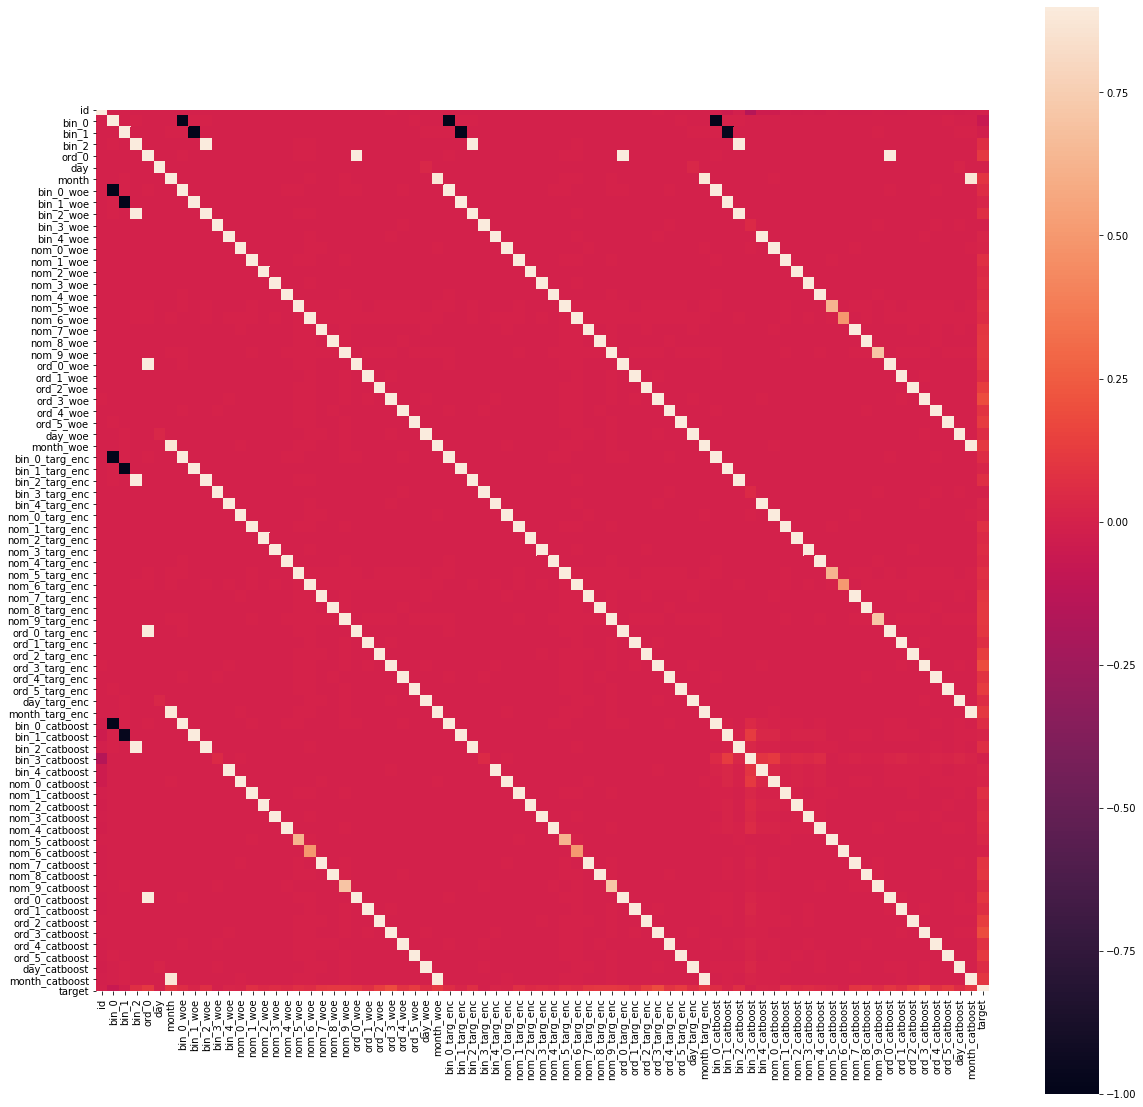

In [198]:
# Encode again, this time on the whole training set. WOEE was done above.
# 再びエンコードを行い、今回は全体の学習セットに対してエンコードを行います。WOEEは上記のように行われました。

# WOEでエンコードしたxは、すでにtrain_featuresに入っている。カラム名の後ろに_woeが付いてる。

# TargetEncoderでエンコードしたxを、train_featuresに追加。カラム名の後ろに_targ_encを付ける。
encoder = ce.TargetEncoder(cols=columns, smoothing=0.2)
encoded_train = encoder.fit_transform(train_features[columns], train_targets).add_suffix('_targ_enc')
train_features = train_features.join(encoded_train)

# CatBoostEncoderでエンコードエンコードしたxを、train_featuresに追加。カラム名の後ろに_catboostを付ける。
encoder = ce.CatBoostEncoder(cols=columns)
encoded_train = encoder.fit_transform(train_features[columns], train_targets).add_suffix('_catboost')
train_features = train_features.join(encoded_train)

# WOEでエンコードしたx
# TargetEncoderでエンコードしたx
# CatBoostEncoderでエンコードしたx
# と y
training_set = train_features.copy()
training_set['target'] = train_targets

# その相関関係
corrmat = training_set.corr()

# その相関関係のヒートマップ
plt.subplots(figsize=(20,20))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [ ]:
# 右端のtargetの部分を見ると、各エンコーダであんまり色の違いはない。
# どれも0.0～0.25くらいの色。あんまり強い相関とは言えないか
# それでも↑でみたような高いAUCを出せているので、相関係数だけみてもダメってことが言いたい？

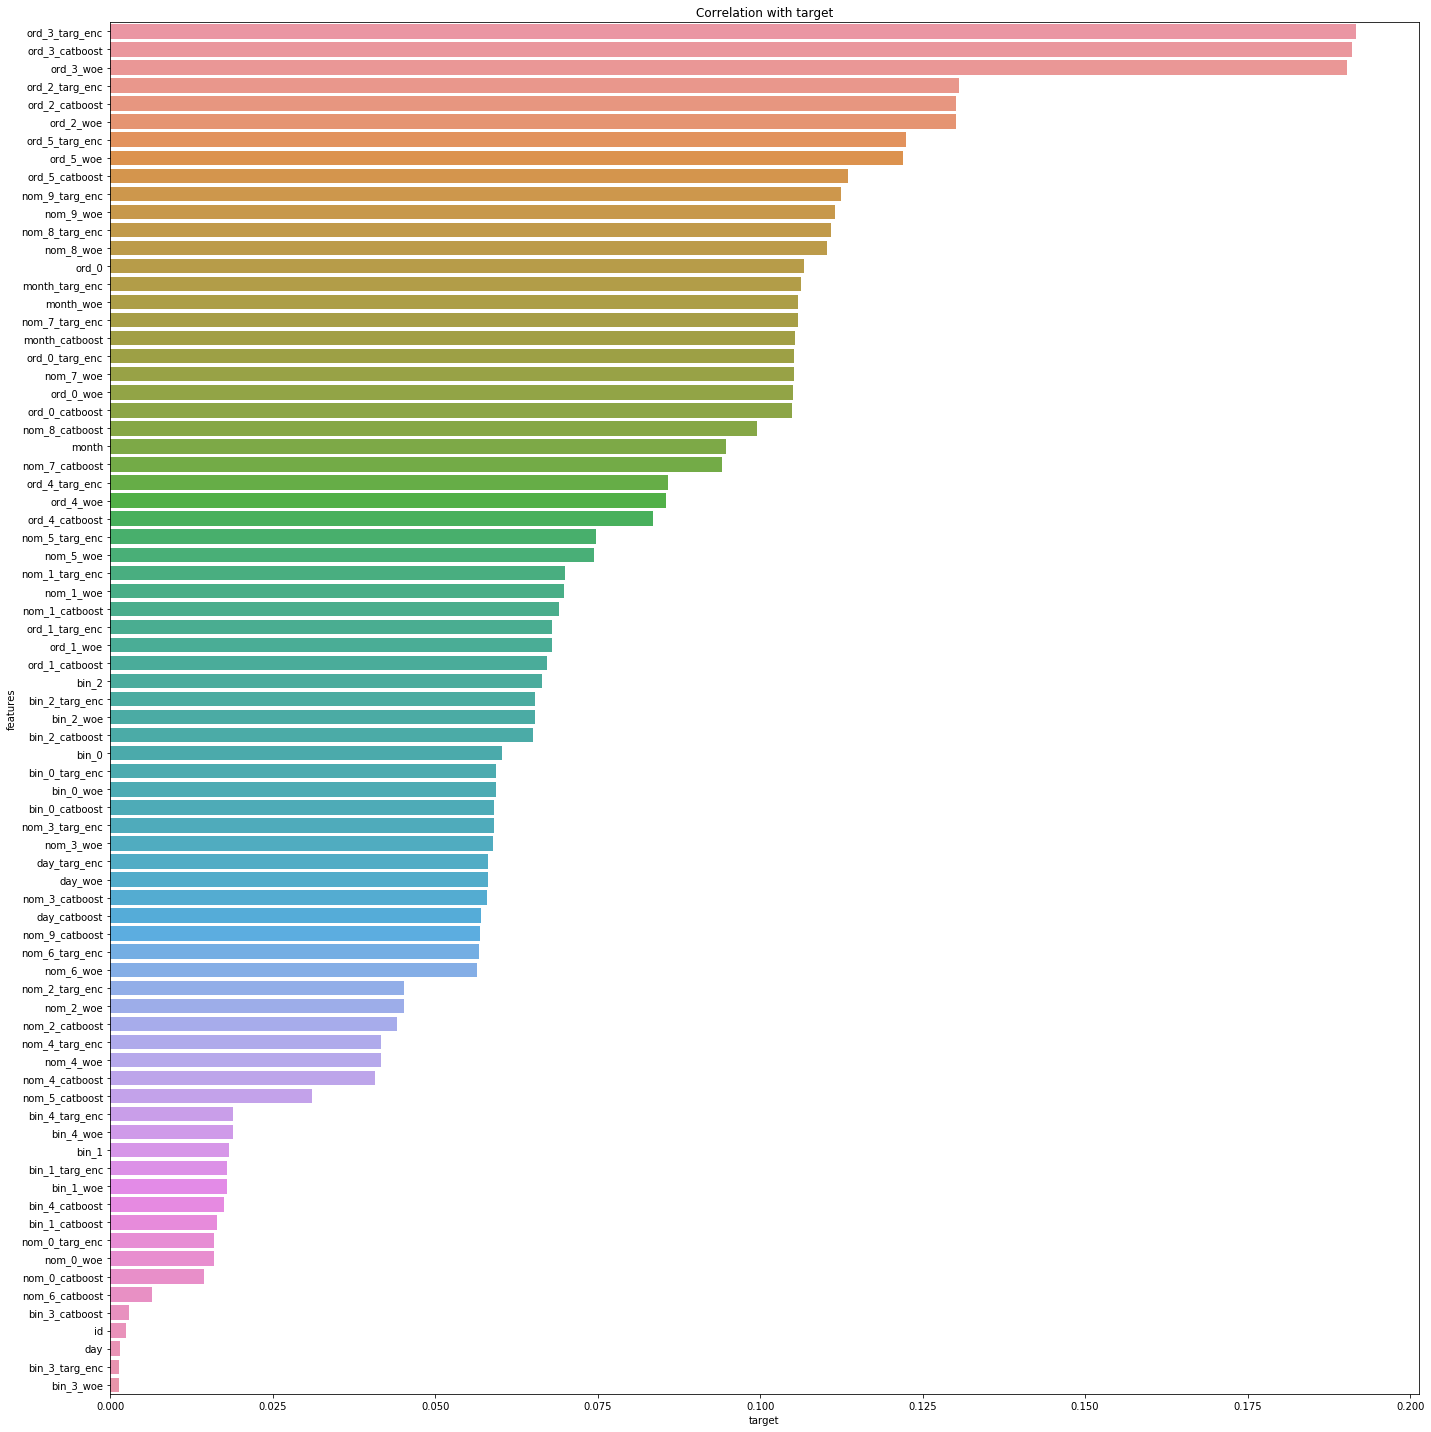

In [199]:
# 相関関係の強い順のグラフ
# 各エンコーダで順位が入り乱れている
corr_with_target = corrmat['target'].apply(abs).sort_values(ascending=False)
corr_with_target.drop(['target'], inplace=True)
df = pd.DataFrame(data={'features': corr_with_target.index, 'target': corr_with_target.values})
plt.figure(figsize=(20, 20))
sns.barplot(x="target", y="features", data=df)
plt.title('Correlation with target')
plt.tight_layout()
plt.show()

### Other remarks gathered from previous notebooks
### その他、以前のノートから集めた備考

for day and month, both target encoding and WoE encoding   
show higher correlation with target than the original labeling and also than the "trigonometrical" encoding  
日と月については、目標符号化とWoE符号化の両方とも、  
元のラベリングよりも目標との相関が高く、  
また「三角法」符号化よりも高い相関を示している。  
  
for binary and ordinal features,   
WoE encoding alone showed little improvement with respect to the obvious ordinal encodings  
2値特徴と順序特徴については，WoE エンコーディングだけでは，  
明らかな順序エンコーディングに対してほとんど改善が見られませんでした．  
  
Casting WOEEncoder on nominal and cyclical features,   
and using ordinal encoding for binary and ordinal features resultedin an AUC score of 0.78355 on the test set  
WOEEncoderを名目特徴量と周期的特徴量にキャストし、  
2値特徴量と順序特徴量に順序符号化を使用することで、テストセットのAUCスコアは0.78355となりました。  
  
Casting TargetEncoder on all features resulted in an AUC score of 0.78302 on the test set  
全てのフィーチャーにTargetEncoderをキャストすると、テストセットのAUCスコアは0.78302になりました。  

### Using stratified WOE encoding for final output
### 最終出力に層別化されたWOEエンコーディングを使用する

In [201]:
# Encoding training data
df = train_features[columns]
train_encoded = pd.DataFrame()
skf = StratifiedKFold(n_splits=5,shuffle=True).split(df, train_targets)
for tr_in,fold_in in skf:
    encoder = ce.WOEEncoder(cols=columns)
    encoder.fit(df.iloc[tr_in,:], train_targets.iloc[tr_in])
    train_encoded = train_encoded.append(encoder.transform(df.iloc[fold_in,:]),ignore_index=False)

train_encoded = train_encoded.sort_index()

# Encoding test data
encoder = ce.WOEEncoder(cols=columns)
encoder.fit(df, train_targets)
test_encoded = encoder.transform(test_features[columns])

# Fitting
regressor = LogisticRegression(solver='lbfgs', max_iter=1000, C=0.6)
regressor.fit(train_encoded, train_targets)

# Predicting
probabilities = [pair[1] for pair in regressor.predict_proba(test_encoded)]
output = pd.DataFrame({'id': test_features['id'],
                       'target': probabilities})
output.to_csv('submission.csv', index=False)
output.describe()

,id,target
count,400000.000000,400000.000000
mean,799999.500000,0.186582
std,115470.198175,0.164785
min,600000.000000,0.000743
25%,699999.750000,0.061931
50%,799999.500000,0.133894
75%,899999.250000,0.263011
max,999999.000000,0.955384
